## adapted from: https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb

In [1]:
import os,re,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords

import pickle
import string
import gensim

np.random.seed(42)

import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Embedding, Reshape, Activation, Input,Lambda, Dense, Concatenate, Average,Flatten
from keras.layers.merge import Dot
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from collections import OrderedDict

from tqdm import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
%load_ext autoreload
%autoreload 1

Using TensorFlow backend.


In [8]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../')
print(src_dir)
sys.path.append(src_dir)

/home/felipe/auto-tagger/social-tags/notebooks/movielens-imdb/../../


In [9]:
%aimport src.data.movielens_20m_imdb
%aimport src.utils.dataframes

from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.utils.dataframes import sample_rows

In [13]:
VECTORS_DATA_ROOT = os.path.abspath("../../data/vectors/movielens-ml20m-imdb/")
INTERIM_DATA_ROOT = os.path.abspath("../../data/interim/movielens-ml20m-imdb/")


PATH_TO_SAVED_MODELS = os.path.abspath('../../models/')

INTERIM_DATA_ROOT = os.path.abspath("../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-13.csv')

In [30]:
DEFAULT_KERAS_FILTER = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
MAX_TEXT_LENGTH = 1000
NB_DOCS = 500
DIM = 50
CONTEXT_WINDOW_SIZE = 2
# STOPWORDS BREAK W2V!!!!
STOPWORDS = None

TOKENIZER_FILTERS = DEFAULT_KERAS_FILTER
NB_EPOCHS = 10

SEED = 42
np.random.seed(SEED)

In [31]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [32]:
# remove this for production
docs_df = sample_rows(docs_df,NB_DOCS)

In [33]:
corpus = docs_df['synopsis'].values

In [34]:
tokenizer = Tokenizer(filters=TOKENIZER_FILTERS)
tokenizer.fit_on_texts(corpus)

In [35]:
sequences = tokenizer.texts_to_sequences(corpus)

In [36]:
nb_samples = sum(len(seq) for seq in sequences)

In [37]:
# total size of the corpus, in words
# this will be the number of iterations be epoch
nb_samples

565575

In [38]:
# the document marker is just added as another word to every context
# note that it will be averaged with the other words in the context
def generate_data(document_sequences, window_size, vocabulary_size):
    
    maxlen = window_size*2
    
    for doc_index, word_sequence in enumerate(document_sequences):
                  
        text_length = len(word_sequence)
        
        for index_in_document,word in enumerate(word_sequence):
                  
            # these are the words in the context
            contexts = []
               
            # these are the target words (which we'll predict using the context)
            labels = []
        
            context_start = index_in_document - window_size           
            context_end   = index_in_document + window_size
            
            context_words = []
            
            for index_in_context in range(context_start, context_end+1):
                if index_in_document != index_in_context: # index_in_context is the target word
                    if index_in_context >= 0 and index_in_context < text_length: # inner_index must be a valid index
                        context_word = word_sequence[index_in_context]
                        context_words.append(context_word)
                                                                     
            labels.append(word)
                        
            x1 = sequence.pad_sequences([context_words], maxlen=maxlen)
                       
            # needs to be at least one or the index will be interpreted as a mask    
            x2 = np.array([doc_index+1])
                                   
            x = [x1,x2]
            
            y = np_utils.to_categorical(labels,vocabulary_size)           
            
#             print("contexts is: {}".format(contexts))
#             print("x1 is: {}".format(x1.shape))
#             print("x2 is: {}".format(x2.shape))
#             print("y is: {}".format(y.shape))
#             return
            
            yield (x,y) 

In [52]:
VOCAB_SIZE=len(tokenizer.word_index) + 1
VOCAB_SIZE

28510

In [49]:
input1 = Input(shape=(CONTEXT_WINDOW_SIZE*2,))
x1 = Embedding(VOCAB_SIZE,output_dim=DIM,name="word_embeddings")(input1)
x1 = Lambda(lambda x: K.mean(x, axis=1))(x1)

input2 = Input(shape=(1,))
x2 = Embedding(NB_DOCS+1,output_dim=DIM,name="document_embeddings")(input2)
x2 = Flatten()(x2)

x = Average()([x1,x2])

outputs = Dense(VOCAB_SIZE,activation='softmax')(x)

In [50]:
pvdm = Model(inputs=[input1,input2],outputs=outputs)
pvdm.compile(loss='categorical_crossentropy', optimizer='adagrad')

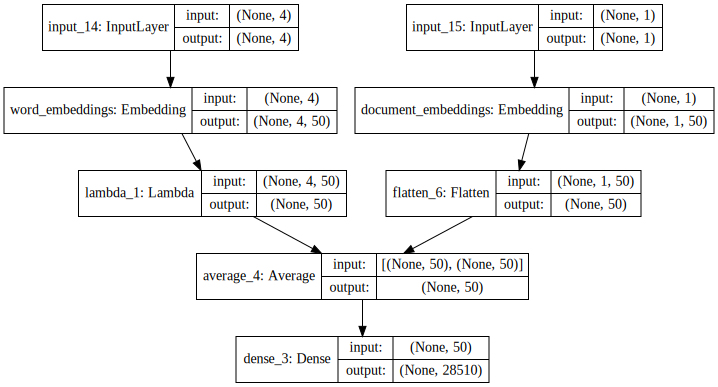

In [51]:
SVG(model_to_dot(pvdm,show_shapes=True).create(prog='dot', format='svg'))

In [53]:
avg_iter_second = 50
num_iterations = (nb_samples * NB_EPOCHS)

rough_time_in_hours = (num_iterations / avg_iter_second) / (60 * 60)
rough_time_in_hours

31.420833333333334

In [ ]:
# xs = []
# ys = []

# for x, y in generate_data(document_sequences=sequences, window_size=CONTEXT_WINDOW_SIZE, vocabulary_size=len(tokenizer.word_index)+1):
#     xs.append(x)
#     ys.append(y)
# xs[0],ys[0],xs[1],ys[1],xs[2],xs[3],xs[4]

In [ ]:
for epoch in range(NB_EPOCHS):
    loss = 0.
    for x, y in tqdm(generate_data(document_sequences=sequences, window_size=CONTEXT_WINDOW_SIZE, vocabulary_size=VOCAB_SIZE)):
        
        loss += pvdm.train_on_batch(x, y)
    print(epoch, loss)

26887it [03:30, 131.99it/s]

## save the model

In [ ]:
path = PATH_TO_SAVED_MODELS+"/doc2vec-pvdm-model-{}.p".format(DIM)

In [ ]:
pvdm.save(path)

## write word vectors

In [ ]:
path_to_word_vectors_file = VECTORS_DATA_ROOT+'/doc2vec-pvdm-word-vectors-{}.txt'.format(DIM)
f = open(path_to_word_vectors_file ,'w')
f.write(' '.join([str(V-1), str(DIM)]))
f.write('\n')
word_embeddings =  pvdm.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(word_embeddings[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format(path_to_word_vectors_file, binary=False)

In [ ]:
w2v.most_similar(positive=['bad'])

## write the document vectors

In [ ]:
path_to_document_vectors_file = VECTORS_DATA_ROOT+'/doc2vec-pvdm-document-vectors-{}.txt'.format(DIM)
f = open(path_to_document_vectors_file ,'w')
f.write(' '.join([str(NB_DOCS), str(DIM)]))
f.write('\n')

In [ ]:
# word_embeddings =  pvdm.get_weights()[0]
doc_embeddings = pvdm.get_weights()[1]

In [ ]:
# one weight for the bias and another one for each document
doc_embeddings.shape

In [ ]:
for i,document_id in enumerate(doc_embeddings):
    if i == 0:
        continue # bias
        
    # document_embedding i refers to document i-1
    
    document_title = docs_df.iloc[i-1]['title']
    document_vector = doc_embeddings[i]
    
    f.write(str(i))
    f.write(' ')
    f.write(' '.join(map(str, list(document_vector))))
    f.write('\n')
f.close()

In [ ]:
f.close()

## let's see if the pseudo_documents are good representations for the documents.

One way to find this is to fetch the most similar documents to a given document￼

In [ ]:
gensim_model = gensim.models.KeyedVectors.load_word2vec_format(path_to_document_vectors_file, binary=False)

In [ ]:
def get_title(document_index, source_dataframe):
    return source_dataframe.iloc[document_index]['title']

In [ ]:
def get_tags(document_index, source_dataframe):
    return ','.join(source_dataframe.iloc[document_index]['unique_tags'].split(',')[:4])

In [ ]:
def most_similar(document_index,source_dataframe,gensim_w2v_model):
    tuples = gensim_w2v_model.most_similar(positive=[str(document_index+1)])
    
    print("title for source document is: {}".format(get_title(document_index, source_dataframe)))
    
    return [ (index, get_title(int(index),source_dataframe), similarity) for index,similarity in tuples ]    

In [ ]:
most_similar(227,docs_df,gensim_model)

In [ ]:
most_similar(62,docs_df,gensim_model)

In [ ]:
most_similar(248,docs_df,gensim_model)

In [ ]:
w2v.most_similar(positive=['can'])